In [1]:
import yaml
import healpy as hp
import numpy as np
import os
import scipy

from plancklens import utils

from jointmap.plots import CMBLensingPlot 

from delensalot.core import cachers

import os
import numpy as np

from delensalot.core.iterator import statics

import yaml

import matplotlib.pyplot as plt

mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
from os.path import join as opj
import os
from plancklens import utils


def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

cls_path = opj(os.environ['HOME'], 'jointmap', 'data')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]

from plancklens.utils import cli

ls = np.arange(cls_rot.size)
factor = cli(ls*(ls+1)/2)
cls_rot = cls_rot*factor**2.



caso_s4 = "" #cmb-s4
caso_so = "_so"
caso_spt = "_spt"

caso = caso_s4

SO_name = "so"
SPT_name = "spt"
S4_name = "s4"
names = {caso_s4:S4_name, caso_so:SO_name, caso_spt:SPT_name}

name = names[caso]
dir = f"{name}data/"
print(dir)


from plancklens import nhl, n0s, qresp

nlev_tdict = {caso_s4: 1., caso_so: 6., caso_spt: 1.6}
beam_fwhm_dict = {caso_s4: 1., caso_so: 1.4, caso_spt: 1.4}

nlev_t = nlev_tdict[caso]
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm = beam_fwhm_dict[caso]
cls_unl_fid = cls_unl
lmin_cmb = 30
lmin_blm, lmin_elm, lmin_tlm = lmin_cmb, lmin_cmb, lmin_cmb
lmax_cmb = 4000
itermax = 10
ret_curl = True

qe_key_A = f"x_p"
qe_key_B = f"a_p"
source_A = "x"
source_B = "a"

lmax_qlm = 5120

def get_noises(it, qe_key_A, source_A):
    fal, dat_delcls, cls_w, cls_f = np.load(f"{dir}fal_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}dat_delcls_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
    cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
    cls_ivfs = dict()


    for i, a in enumerate(['t', 'e', 'b']):
        for j, b in enumerate(['t', 'e', 'b'][i:]):
            if np.any(cls_ivfs_arr[i, j + i]):
                cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

    #n_gg_A_B = nhl.get_nhl(qe_key_A, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #cross-noise
    n_gg_A_A = nhl.get_nhl(qe_key_A, qe_key_A, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)#[1] #auto-noise
    r_gg_true_A = qresp.get_response(qe_key_A, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)#[1] #XX
    #N0_unbiased_A_B = n_gg_A_B * utils.cli(r_gg_true_A * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
    #N0_unbiased_A_A = n_gg_A_A * utils.cli(r_gg_true_A * r_gg_true_A)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
    return n_gg_A_A, r_gg_true_A

s4data/


In [3]:
ngg, rgg = get_noises(0, "p_p", "p")
NQEp, NQEc = ngg[0]*utils.cli(rgg[0]**2.), ngg[1]*utils.cli(rgg[1]**2.)
rggQEp, rggQEc = rgg[0], rgg[1]

ngg, rgg = get_noises(10, "p_p", "p")
NMAPp, NMAPc = ngg[0]*utils.cli(rgg[0]**2.), ngg[1]*utils.cli(rgg[1]**2.)
rggMAPp, rggMAPc = rgg[0], rgg[1]


In [4]:
ngg, rgg = get_noises(0, "a_p", "a")
NQEa = ngg[0]*utils.cli(rgg[0]**2.)
ngg, rgg = get_noises(10, "a_p", "a")
NMAPa = ngg[0]*utils.cli(rgg[0]**2.)
rggMAPa = rgg[0]

ngg, rgg = get_noises(0, "f_p", "f")
NQEf = ngg[0]*utils.cli(rgg[0]**2.)
ngg, rgg = get_noises(10, "f_p", "f")
NMAPf = ngg[0]*utils.cli(rgg[0]**2.)
rggMAPf = rgg[0]

In [5]:
rggs = [rggMAPa, rggMAPf, rggMAPp, rggMAPc]

In [12]:
dir = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/afpo_version_afpo_20_02_recs/p_p_sim0000afpo_20_02/"

x = 0

nbreak, nmax = 9, 18

itr = 1
mf_QE = np.mean([np.load(dir+f"plm_gradpdet_it{itr:03}_sim{1000+x}.npy") for x in range(nbreak)], axis = 0)
mf_QE = np.mean([np.load(dir+f"plm_gradpdet_it{itr:03}_sim{1000+x}.npy") for x in range(nbreak, nmax)], axis = 0)


mfs = {}

simidx = 0
for simidx in range(4):
    dir = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/afpo_version_afpo_20_02_recs/p_p_sim{simidx:04}afpo_20_02/"
    nbreak, nmax = 13, 26
    itr = 15
    mf_MAP_A = np.mean([np.load(dir+f"plm_gradpdet_it{itr:03}_sim{1000+x}.npy") for x in range(nbreak)], axis = 0)
    mf_MAP_B = np.mean([np.load(dir+f"plm_gradpdet_it{itr:03}_sim{1000+x}.npy") for x in range(nbreak, nmax)], axis = 0)
    mfs[simidx] = [mf_MAP_A, mf_MAP_B]
#itr = 18
#mf_MAP_max_A = np.mean([np.load(dir+f"plm_gradpdet_it{itr:03}_sim{1000+x}.npy") for x in range(nbreak)], axis = 0)
#mf_MAP_max_B = np.mean([np.load(dir+f"plm_gradpdet_it{itr:03}_sim{1000+x}.npy") for x in range(nbreak, nmax)], axis = 0)

In [7]:
"""import itertools
combs = list(itertools.combinations(np.arange(0, 15), 2))
len(combs)
mfs_temp = [np.load(dir+f"plm_gradpdet_it{itr:03}_sim{1000+x}.npy") for x in range(nmax)]
cls = []
for i, j in combs:
    if i == j:
        continue
    cls += [hp.alm2cl(mfs_temp[i][0], mfs_temp[j][0])]
cls = np.mean(cls, axis = 0)"""

'import itertools\ncombs = list(itertools.combinations(np.arange(0, 15), 2))\nlen(combs)\nmfs_temp = [np.load(dir+f"plm_gradpdet_it{itr:03}_sim{1000+x}.npy") for x in range(nmax)]\ncls = []\nfor i, j in combs:\n    if i == j:\n        continue\n    cls += [hp.alm2cl(mfs_temp[i][0], mfs_temp[j][0])]\ncls = np.mean(cls, axis = 0)'

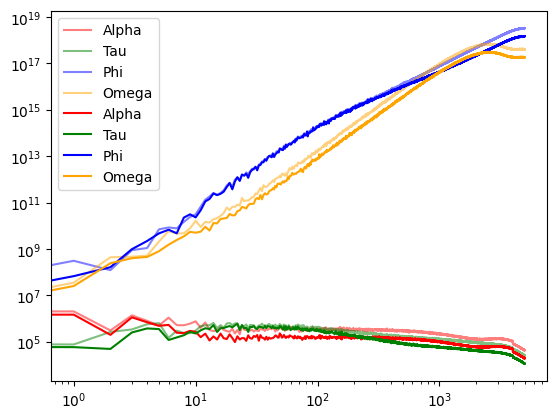

In [7]:

plt.loglog(hp.alm2cl(mf_QE[0]), label = "Alpha", color = "red", alpha = 0.5)
plt.loglog(hp.alm2cl(mf_QE[1]), label = "Tau", color = "green", alpha = 0.5)
plt.loglog(hp.alm2cl(mf_QE[2]), label = "Phi", color = "blue", alpha = 0.5)
plt.loglog(hp.alm2cl(mf_QE[3]), label = "Omega", color = "orange", alpha = 0.5)


plt.loglog(hp.alm2cl(mf_MAP_A[0]), label = "Alpha", color = "red")
plt.loglog(hp.alm2cl(mf_MAP_A[1]), label = "Tau", color = "green")
plt.loglog(hp.alm2cl(mf_MAP_A[2]), label = "Phi", color = "blue")
plt.loglog(hp.alm2cl(mf_MAP_A[3]), label = "Omega", color = "orange")

plt.legend()

In [10]:
from iterativefg import utils as itu

bin_edges = np.arange(2, 4000, 4)
bin_edges = np.append(np.arange(2, 500, 2), np.arange(500, 4000, 2))
bin = lambda x: itu.bin_theory(x, bin_edges)


/tmp/ipykernel_1352768/1357053631.py:10: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


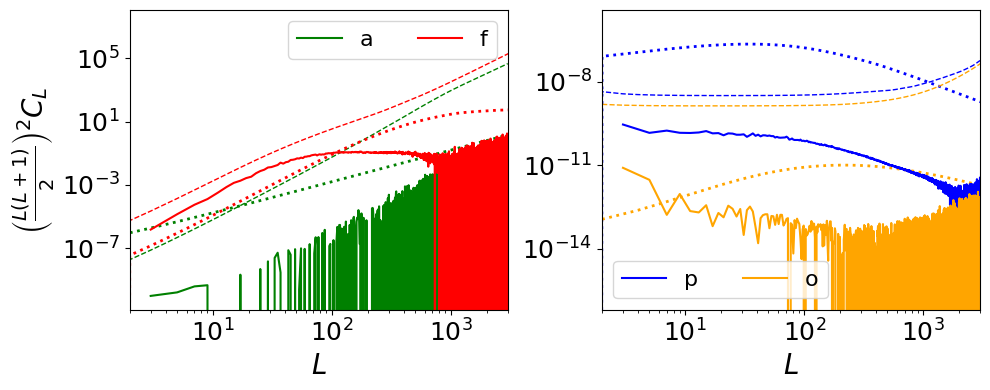

In [13]:
fig, axs = plt.subplots(ncols = 2, figsize = (10, 4))

cl = hp.alm2cl(mf_QE[2])
ls = np.arange(cl.size)
factor = (ls*(ls+1)/2)**2#/np.pi#*1e7

ell = ls
ACB = 7
ns = 1
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0

HOME = os.environ['HOME']
tau_dir = opj(HOME, 'jointmap', 'data', 'tau_lensing_data')
tau_phi = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_ptau.txt"))
tau_tau = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_tautau.txt")) 
tau_tau = tau_tau[:ell.size]
#plt.loglog(cl*factor*utils.cli(rggQEp**2)[:5001], label = "Phi", color = "red")
"""cl = hp.alm2cl(mf_MAP_A[2])
ls = np.arange(cl.size)
plt.loglog(cl*factor*utils.cli(rggMAPp**2)[:5001], label = "Phi", color = "blue")

cl = hp.alm2cl(mf_MAP_max_A[2])
ls = np.arange(cl.size)
plt.loglog(cl*factor*utils.cli(rggMAPp**2)[:5001], label = "Phi", color = "orange")"""

colors = ["green", "red", "blue", "orange"]
names = [r"$\alpha$", r"$\tau$", r"$\phi$", r"$\omega$"]
theory = [cls_alpha, tau_tau, cls_unl["pp"][:ls.size], cls_rot[:ls.size]]
names = ["a", "f", "p", "o"]
cls = {}
for x in range(4):
    index = 0 if x < 2 else 1
    ax = axs[index]
    ax.plot(ls, factor*utils.cli(rggs[x])[:5001], color = colors[x], ls = "--", lw = 1, zorder = 0)

    Nsims = 4
    clmean = 0
    for simidx in range(Nsims):
        mf_MAP_A, mf_MAP_B = mfs[simidx]
        cl = hp.alm2cl(mf_MAP_A[x], mf_MAP_B[x])
        clmean += cl
    clmean /= 4
    val = clmean*factor*utils.cli(rggs[x]**2)[:5001]
    el, y = bin(val)
    ax.loglog(el, y, color = colors[x], label = names[x])
    ax.plot(theory[x]*factor, color = colors[x], ls = ":", lw = 2, zorder = 0)

    temp = {"mf": (el, y), "th": theory[x]*factor, "n": factor*utils.cli(rggs[x])[:5001]}
    cls[names[x]] = temp

    ax.legend(fontsize = 16, ncol = len(colors))
    ax.set_xlim(2, 3e3)
    ax.set_xlabel(r"$L$", fontsize = 20)
    ax.tick_params(axis='both', labelsize=18)
    if index == 0:
        ax.set_ylabel(r"$\left(\frac{L(L+1)}{2}\right)^2 C_L$", fontsize = 20)
fig.tight_layout()
fig.savefig("mean_fields.pdf", dpi = 300)

In [25]:
np.save("cls_mean_field.npy", cls)

In [13]:
cls

{'a': {'mf': (array([2.5000e+00, 3.5000e+00, 4.5000e+00, ..., 3.9965e+03, 3.9975e+03,
          3.9985e+03]),
   array([ 3.51440911e-12,  1.73980793e-10,  2.17405729e-10, ...,
          -2.89798847e+00,  3.78794833e-01,  1.26273142e+00])),
  'th': array([0.00000000e+00, 3.14159265e-07, 9.42477796e-07, ...,
         3.92463494e+00, 3.92620542e+00, 3.92777622e+00]),
  'n': array([0.00000000e+00, 2.10635143e-09, 1.89577537e-08, ...,
         3.87853895e+06, 3.89286961e+06, 3.90723145e+06])},
 'f': {'mf': (array([2.5000e+00, 3.5000e+00, 4.5000e+00, ..., 3.9965e+03, 3.9975e+03,
          3.9985e+03]),
   array([-1.28210773e-07,  1.88699816e-06,  1.50371098e-05, ...,
          -1.04570645e+01,  8.65571345e+00,  1.31872044e+01])),
  'th': array([0.00000000e+00, 0.00000000e+00, 3.57760784e-08, ...,
         6.42801850e+01, 6.42858492e+01, 6.42915093e+01]),
  'n': array([0.00000000e+00, 6.22488980e-07, 5.59039037e-06, ...,
         1.51762650e+07, 1.52317454e+07, 1.52873657e+07])},
 'p': {'mf':

In [11]:
alpha = hp.read_alm("/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot/simswalpha/sim_0000_alpha_lm.fits")
alpha = utils.alm_copy(alpha, 5000)

phi = hp.read_alm("/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot/simswalpha/sim_0000_plm.fits")
phi = utils.alm_copy(phi, 5000)

FileNotFoundError: [Errno 2] No such file or directory: '/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot/simswalpha/sim_0000_alpha_lm.fits'

In [ ]:
rec_dir = "/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot_version_mf_test_1_recs/p_p_sim0000mf_test_1/"


ii = 0

plm_rec = np.load(rec_dir + "phi_plm_it000.npy")
plm_rec = np.split(plm_rec, 3)[ii]

read = lambda idx: np.split(np.load(rec_dir + f"plm_gradpdet_it001_sim{2000+idx:04}.npy"), 3)[ii].squeeze()

In [ ]:
N = 15
lista = np.cumsum([read(i) for i in range(N)], axis = 0)
denominator = np.cumsum([1 for i in range(N)], axis = 0)
lista = lista/denominator[:, np.newaxis]

In [ ]:
grad = np.split(np.load(rec_dir+"plm_gradplik_it000.npy"), 3)[ii]

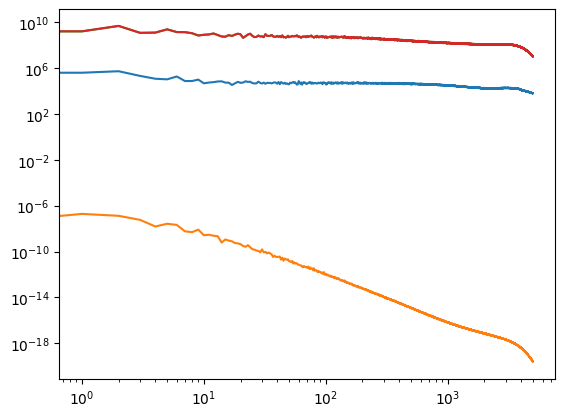

In [ ]:
plt.loglog(hp.alm2cl(lista[-1]))
plt.loglog(hp.alm2cl(plm_rec))
plt.loglog(hp.alm2cl(grad+lista[-1]))
plt.loglog(hp.alm2cl(grad))

In [ ]:
plm0 = np.load(rec_dir + "phi_plm_it000.npy")
hessian_term = np.load(rec_dir+"hessian/rlm_sn_0_p.npy")
plm1 = plm0 + hessian_term
plm0 = np.split(plm0, 3)[ii]
plm1 = np.split(plm1, 3)[ii]

In [ ]:
clcross = hp.alm2cl(plm0, alpha)
clcross1 = hp.alm2cl(plm1, alpha)

claa = hp.alm2cl(alpha)
clauto = hp.alm2cl(plm0)
clauto1 = hp.alm2cl(plm1)

/tmp/ipykernel_32591/445360641.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(clcross/claa)
/tmp/ipykernel_32591/445360641.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(clcross1/claa)


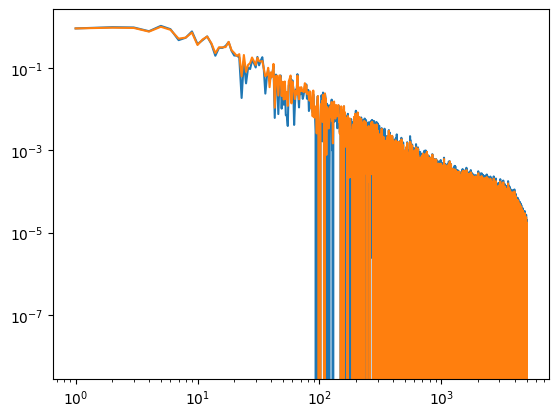

In [ ]:
plt.loglog(clcross/claa)
plt.loglog(clcross1/claa)